# Medical Manuscript Helper

## 医学论文助手

### 1. 导入数据

In [545]:
import pandas as pd
data = pd.read_csv('./data/duct/duct.csv')

### 2. 数据基本信息

* 小数位数设置

In [546]:
# pd.set_option('precision', 6) 

* 行数，列数

In [547]:
data.shape

(474, 9)

* 分组情况（按第一列分组）

In [548]:
data.groupby(data.columns[0]).size()

group
0    255
1    219
dtype: int64

* 数据前5项

In [549]:
data.head(5).style

,group,age,menopause,gestation,pain,ectasia,multiple,distance,size
0,0,47,0,1,1,0,1,0,1
1,0,47,0,1,1,0,1,0,0
2,0,44,0,1,0,0,1,0,0
3,0,44,0,1,0,0,1,nan,1
4,0,44,0,1,0,0,1,0,1


* 数据基本特征

In [550]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474 entries, 0 to 473
Data columns (total 9 columns):
group        474 non-null int64
age          474 non-null int64
menopause    474 non-null int64
gestation    474 non-null int64
pain         474 non-null int64
ectasia      474 non-null int64
multiple     474 non-null int64
distance     393 non-null float64
size         468 non-null float64
dtypes: float64(2), int64(7)
memory usage: 33.4 KB


* 数据基本统计信息

In [551]:
data.describe()

,group,age,menopause,gestation,pain,ectasia,multiple,distance,size
count,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,393.000000,468.000000
mean,0.462025,41.221519,0.128692,0.860759,0.179325,0.080169,0.601266,0.447837,0.502137
std,0.499083,10.785016,0.335212,0.346563,0.384029,0.271841,0.490155,0.497905,0.500530
min,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,35.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,42.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,1.000000,47.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,77.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


* 数据类型

In [552]:
data.dtypes

group          int64
age            int64
menopause      int64
gestation      int64
pain           int64
ectasia        int64
multiple       int64
distance     float64
size         float64
dtype: object

### 3. 数据可视化

In [553]:
import matplotlib
%config InlineBackend.figure_format = 'svg'

* 单变量图表

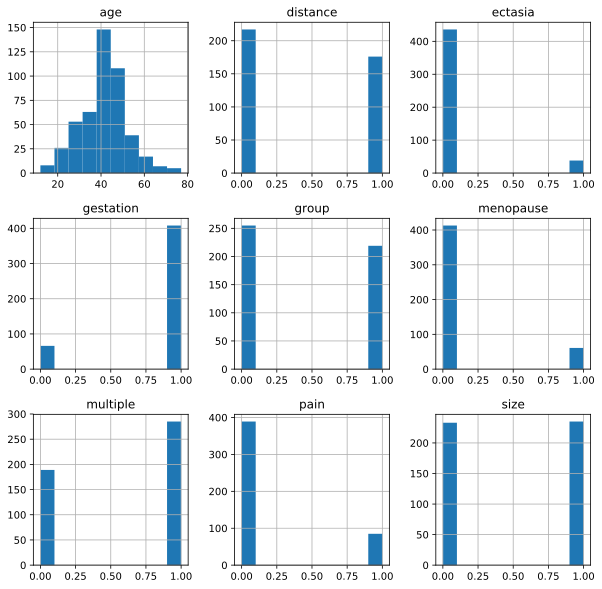

In [554]:
data.hist(figsize=(10,10));

* 多变量图表

In [556]:
# pd.plotting.scatter_matrix(data, figsize=(15,15));

### 4. 评估算法

* 数据缺失值处理

In [555]:
traindata = data.dropna()

* 分离数据

In [557]:
from sklearn.model_selection import train_test_split
array = traindata.values
X = array[:,1:]
Y = array[:,0]
testsize = 0.2
seed = 1
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=testsize, random_state=seed)

* 评估模型

In [559]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

models = {}
models['LR'] = LogisticRegression(solver='liblinear')
models['LDA'] = LinearDiscriminantAnalysis()
models['KNN'] = KNeighborsClassifier()
models['CART'] = DecisionTreeClassifier()
models['NB'] = GaussianNB()
models['SVM'] = SVC(gamma='scale')

results = []
for key in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(models[key], X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    print(f'{key}: {cv_results.mean()}')

LR: 0.6572043010752688
LDA: 0.6505376344086022
KNN: 0.6410752688172044
CART: 0.646989247311828
NB: 0.6569892473118281
SVM: 0.6536559139784947
